/Users/jure/PhD/coding/tracking/cloudtracker/ct_venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


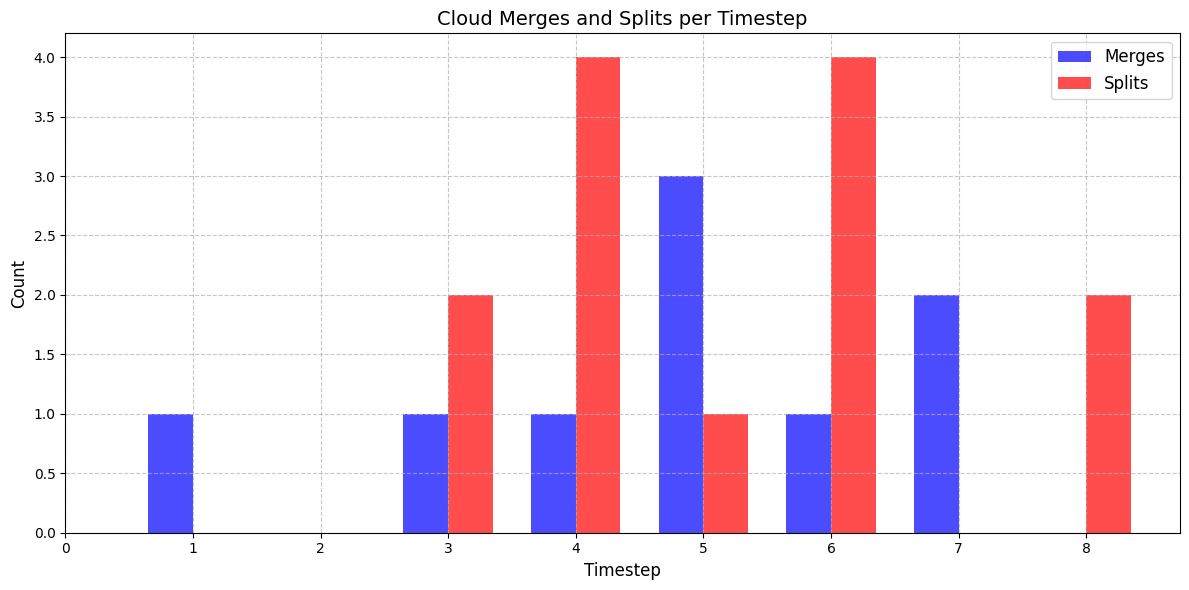

Total merge events: 9
Total split events: 13


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Load merge and split variables
merges_count = dataset.variables['merges_count'][:]
splits_count = dataset.variables['splits_count'][:]
time_steps = dataset.variables['merges_count'].shape[1]  # Number of timesteps

# Calculate total merges and splits per timestep
total_merges_per_timestep = np.nansum(merges_count > 0, axis=0)
total_splits_per_timestep = np.nansum(splits_count > 0, axis=0)

# Create the plot
plt.figure(figsize=(12, 6))
time_indices = np.arange(time_steps)
bar_width = 0.35

plt.bar(time_indices - bar_width/2, total_merges_per_timestep, 
        width=bar_width, label='Merges', color='blue', alpha=0.7)
plt.bar(time_indices + bar_width/2, total_splits_per_timestep, 
        width=bar_width, label='Splits', color='red', alpha=0.7)

plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Cloud Merges and Splits per Timestep', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(time_indices)
plt.tight_layout()
plt.show()

# Print summary statistics
total_merges = np.nansum(merges_count > 0)
total_splits = np.nansum(splits_count > 0)
print(f"Total merge events: {total_merges}")
print(f"Total split events: {total_splits}")

dataset.close()

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_64133/14043759.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(active_clouds))


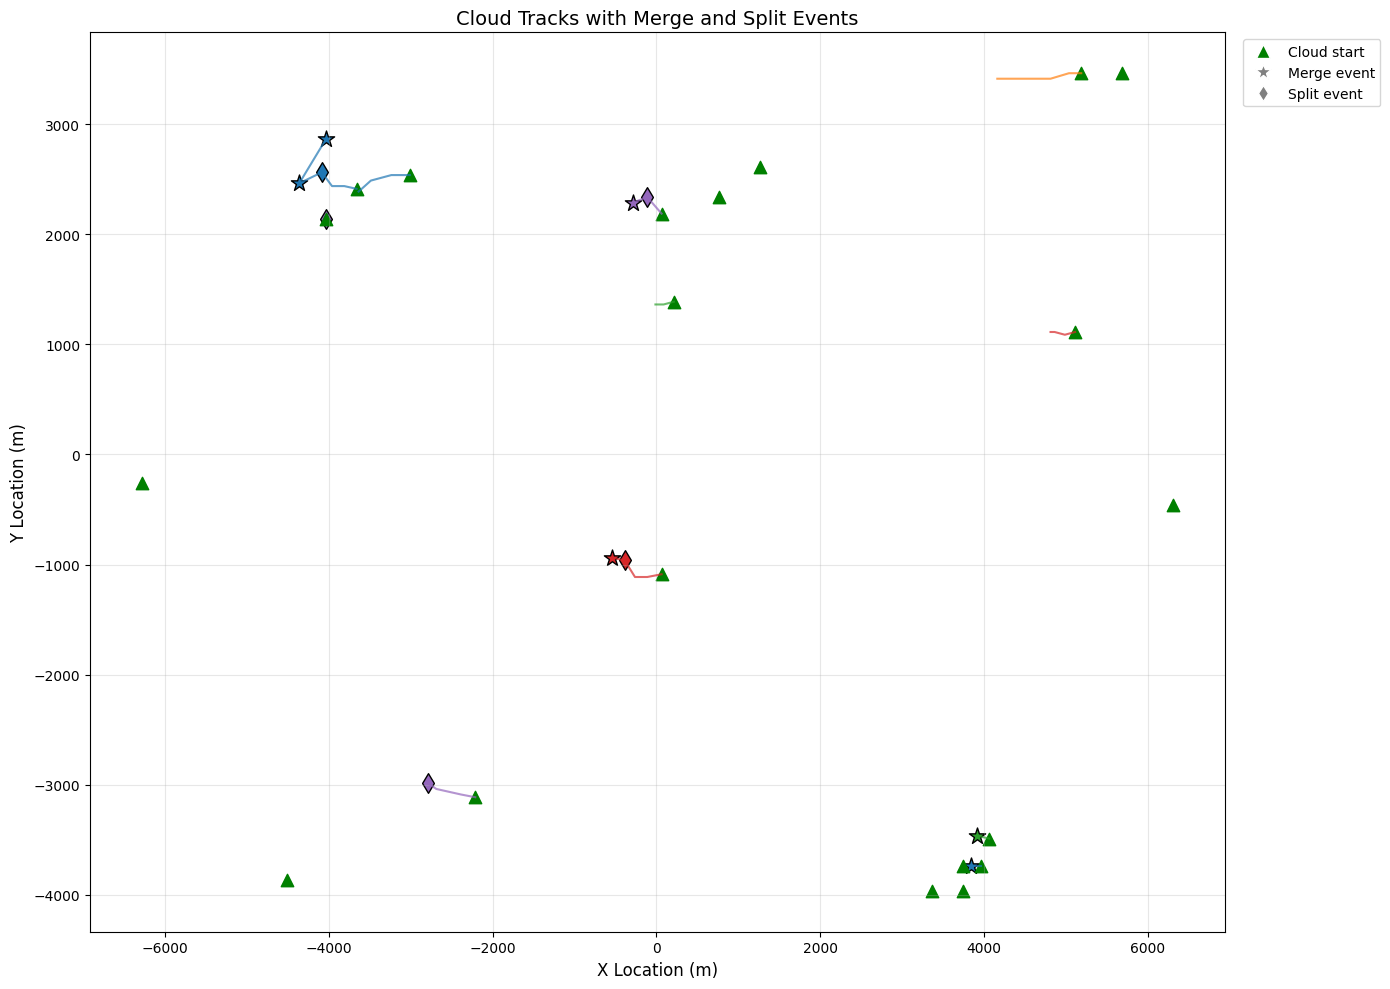

In [2]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import matplotlib.cm as cm

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Load all necessary variables
valid_tracks = dataset.variables['valid_track'][:]
x_centers = dataset.variables['location_x'][:]
y_centers = dataset.variables['location_y'][:]
merges_count = dataset.variables['merges_count'][:]
splits_count = dataset.variables['splits_count'][:]
merged_into = dataset.variables['merged_into'][:]
split_from = dataset.variables['split_from'][:]

# Filter for valid clouds (both complete and partial lifecycles for this analysis)
valid_cloud_indices = (np.any(~np.isnan(x_centers), axis=1) & np.any(~np.isnan(y_centers), axis=1))
active_clouds = np.where(valid_cloud_indices)[0]

# Plot setup
plt.figure(figsize=(14, 10))
colors = cm.get_cmap('tab10', len(active_clouds))

# Create a plot for a subset of clouds (adjust as needed for readability)
max_clouds_to_plot = min(20, len(active_clouds))
selected_clouds = active_clouds[:max_clouds_to_plot]

# Plot each cloud track
for i, cloud_idx in enumerate(selected_clouds):
    # Get valid timesteps for this cloud
    valid_idx = ~np.isnan(x_centers[cloud_idx, :]) & ~np.isnan(y_centers[cloud_idx, :])
    
    if np.any(valid_idx):
        # Plot the cloud track
        plt.plot(x_centers[cloud_idx, valid_idx], y_centers[cloud_idx, valid_idx], '-', 
                color=colors(i), linewidth=1.5, alpha=0.7,
                label=f'Cloud {cloud_idx}')
        
        # Mark timesteps with merge events
        merge_timesteps = np.where(valid_idx & (merges_count[cloud_idx, :] > 0))[0]
        if len(merge_timesteps) > 0:
            plt.scatter(x_centers[cloud_idx, merge_timesteps], 
                       y_centers[cloud_idx, merge_timesteps],
                       marker='*', s=150, color=colors(i), edgecolor='black', 
                       label=f'Cloud {cloud_idx} merges' if i == 0 else '')
        
        # Mark timesteps with split events
        split_timesteps = np.where(valid_idx & (splits_count[cloud_idx, :] > 0))[0]
        if len(split_timesteps) > 0:
            plt.scatter(x_centers[cloud_idx, split_timesteps], 
                       y_centers[cloud_idx, split_timesteps],
                       marker='d', s=100, color=colors(i), edgecolor='black',
                       label=f'Cloud {cloud_idx} splits' if i == 0 else '')
        
        # Mark the start of each cloud track
        start_idx = np.where(valid_idx)[0][0]
        plt.scatter(x_centers[cloud_idx, start_idx], y_centers[cloud_idx, start_idx], 
                   marker='^', s=80, color='green', 
                   label='Cloud start' if i == 0 else '')

# Add labels and legend with custom handles for merge/split events
plt.xlabel('X Location (m)', fontsize=12)
plt.ylabel('Y Location (m)', fontsize=12)
plt.title('Cloud Tracks with Merge and Split Events', fontsize=14)
plt.grid(True, alpha=0.3)

# Create custom legend entries for merge and split markers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Cloud start'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=12, label='Merge event'),
    Line2D([0], [0], marker='d', color='w', markerfacecolor='gray', markersize=8, label='Split event')
]

# Add the legend
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
plt.tight_layout()
plt.show()

dataset.close()

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from netCDF4 import Dataset
import numpy as np

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Load necessary variables
merged_into = dataset.variables['merged_into'][:]
split_from = dataset.variables['split_from'][:]
track_id = dataset.variables['track_id'][:]  # If available, or use indices
valid_tracks = dataset.variables['valid_track'][:]

# Create a directed graph
G = nx.DiGraph()

# Add nodes (clouds)
for i in range(len(valid_tracks)):
    # Use track_id if available, otherwise use index
    node_id = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
    # Add cloud as a node
    G.add_node(node_id, 
               valid=(valid_tracks[i] == 1),
               label=f"Cloud {node_id}")

# Add edges for merges
for i in range(merged_into.shape[0]):
    for t in range(merged_into.shape[1]):
        # Check if there's a merge
        if merged_into[i, t] >= 0:  # -1 means not merged
            source = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
            target = int(merged_into[i, t])
            G.add_edge(source, target, edge_type='merge', timestep=t)

# Add edges for splits
for i in range(split_from.shape[0]):
    for t in range(split_from.shape[1]):
        # Check if there's a split
        if split_from[i, t] >= 0:  # -1 means not split from another cloud
            source = int(split_from[i, t])
            target = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
            G.add_edge(source, target, edge_type='split', timestep=t)

# Create plot
plt.figure(figsize=(12, 10))

# Define node colors based on validity
node_colors = ['green' if G.nodes[n]['valid'] else 'red' for n in G.nodes()]

# Define edge colors based on type
edge_colors = []
for u, v, data in G.edges(data=True):
    if data['edge_type'] == 'merge':
        edge_colors.append('blue')
    else:  # split
        edge_colors.append('red')

# Use spring layout for the graph
pos = nx.spring_layout(G, seed=42, k=0.5)  # k controls the distance between nodes

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, alpha=0.7,
                       connectionstyle='arc3,rad=0.2',  # Curved edges
                       arrowsize=15, arrowstyle='->')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Add a title
plt.title("Cloud Merge and Split Network", fontsize=16)

# Add a legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='Complete lifecycle'),
    Patch(facecolor='red', edgecolor='black', label='Partial lifecycle'),
    Line2D([0], [0], color='blue', lw=2, label='Merge'),
    Line2D([0], [0], color='red', lw=2, label='Split')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()

dataset.close()

KeyError: 'valid'

<Figure size 1200x1000 with 0 Axes>

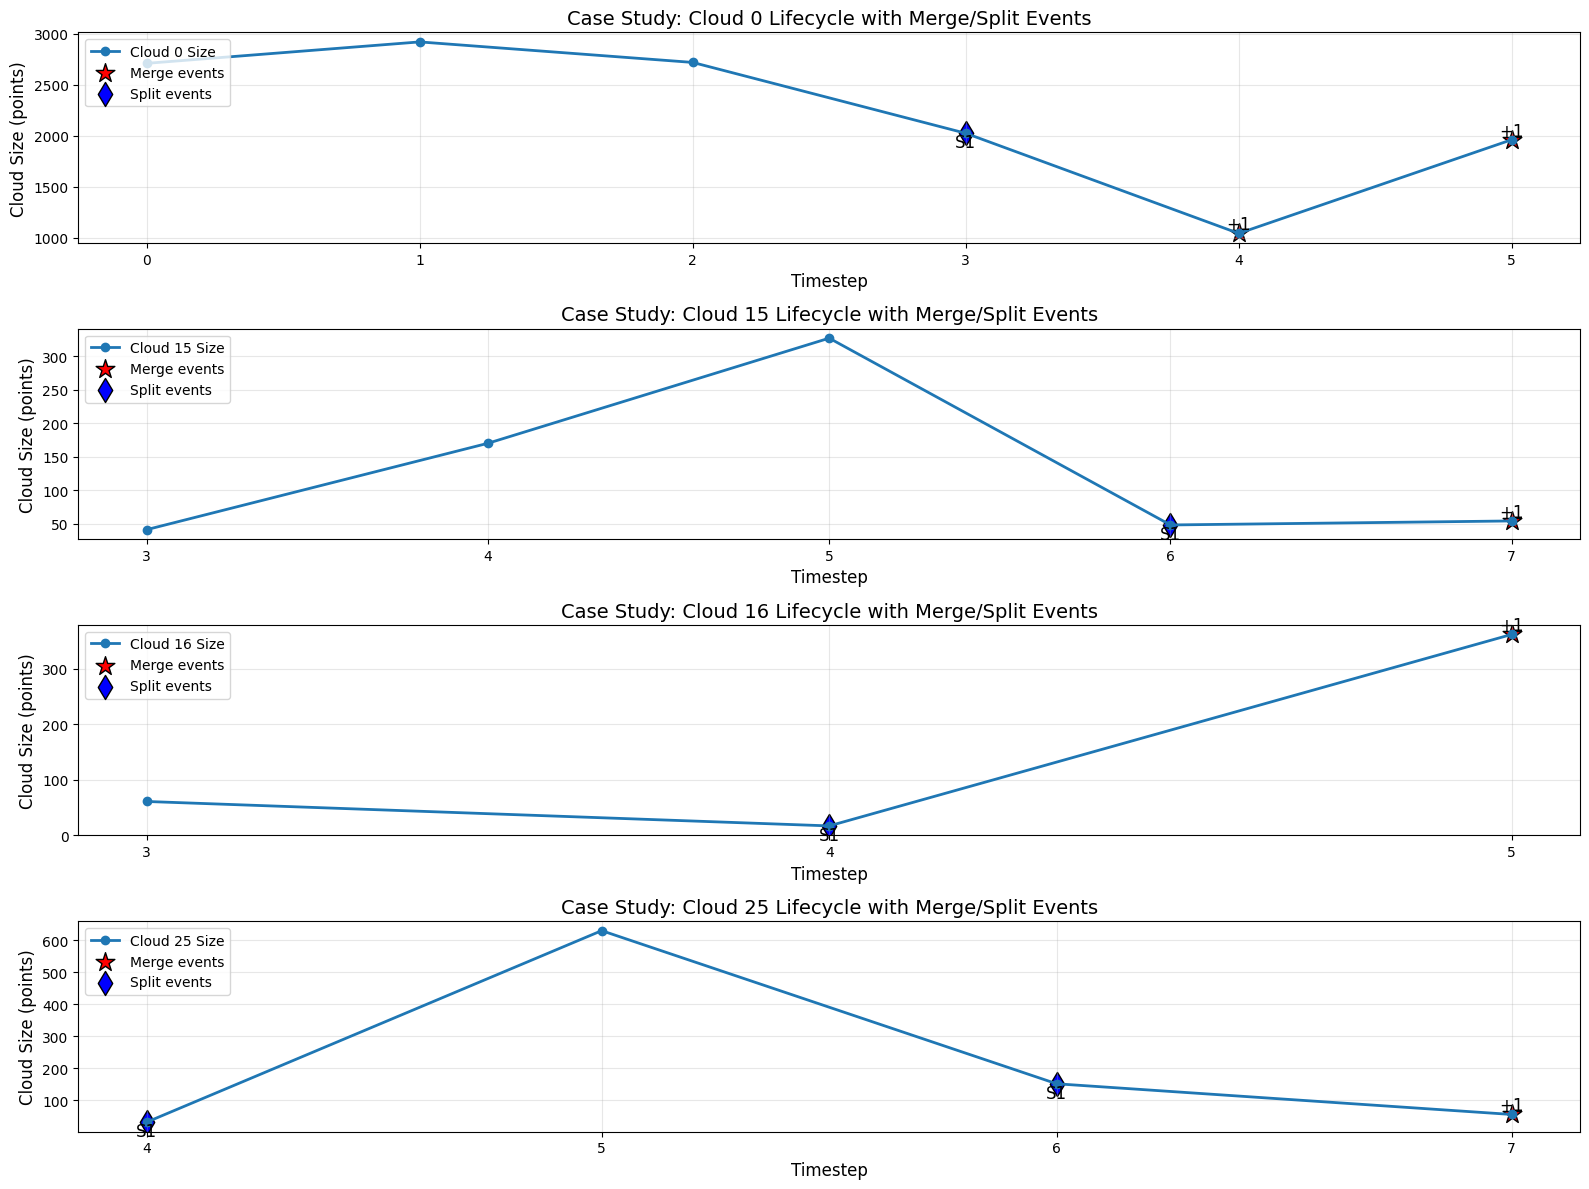

In [5]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Function to find interesting merge/split events
def find_interesting_events(merges_count, splits_count, x_centers, y_centers, merged_into, split_from):
    # Look for clouds involved in both merges and splits
    complex_clouds = []
    
    for i in range(merges_count.shape[0]):
        # Check if this cloud has both merges and splits
        if (np.nansum(merges_count[i,:]) > 0 and np.nansum(splits_count[i,:]) > 0):
            # Ensure the cloud has valid location data
            if np.any(~np.isnan(x_centers[i,:])):
                complex_clouds.append(i)
    
    # If no complex cases found, look for clouds with multiple merges
    if len(complex_clouds) == 0:
        for i in range(merges_count.shape[0]):
            if np.nansum(merges_count[i,:]) > 1:
                if np.any(~np.isnan(x_centers[i,:])):
                    complex_clouds.append(i)
    
    # If still no cases found, look for any cloud with at least one merge
    if len(complex_clouds) == 0:
        for i in range(merges_count.shape[0]):
            if np.nansum(merges_count[i,:]) > 0:
                if np.any(~np.isnan(x_centers[i,:])):
                    complex_clouds.append(i)
    
    return complex_clouds[:5]  # Return up to 5 interesting cases

# Load necessary variables
merges_count = dataset.variables['merges_count'][:]
splits_count = dataset.variables['splits_count'][:]
x_centers = dataset.variables['location_x'][:]
y_centers = dataset.variables['location_y'][:]
merged_into = dataset.variables['merged_into'][:]
split_from = dataset.variables['split_from'][:]
size_var = dataset.variables['size'][:]  # Cloud size

# Find some interesting cases
interesting_clouds = find_interesting_events(merges_count, splits_count, 
                                           x_centers, y_centers, 
                                           merged_into, split_from)

# Case study visualization
plt.figure(figsize=(16, 12))

for i, cloud_idx in enumerate(interesting_clouds):
    plt.subplot(len(interesting_clouds), 1, i+1)
    
    # Get valid timesteps for this cloud
    valid_idx = ~np.isnan(x_centers[cloud_idx, :])
    timesteps = np.where(valid_idx)[0]
    
    if len(timesteps) == 0:
        continue
    
    # Plot cloud size over time
    plt.plot(timesteps, size_var[cloud_idx, timesteps], 'o-', linewidth=2, 
             label=f'Cloud {cloud_idx} Size')
    
    # Mark merge events
    merge_timesteps = np.where(valid_idx & (merges_count[cloud_idx, :] > 0))[0]
    if len(merge_timesteps) > 0:
        plt.scatter(merge_timesteps, size_var[cloud_idx, merge_timesteps], 
                   marker='*', s=200, color='red', edgecolor='black', 
                   label='Merge events')
        
        # Add merge count labels
        for ts in merge_timesteps:
            plt.text(ts, size_var[cloud_idx, ts], f"+{int(merges_count[cloud_idx, ts])}", 
                    fontsize=12, ha='center', va='bottom')
    
    # Mark split events
    split_timesteps = np.where(valid_idx & (splits_count[cloud_idx, :] > 0))[0]
    if len(split_timesteps) > 0:
        plt.scatter(split_timesteps, size_var[cloud_idx, split_timesteps], 
                   marker='d', s=150, color='blue', edgecolor='black', 
                   label='Split events')
        
        # Add split labels
        for ts in split_timesteps:
            plt.text(ts, size_var[cloud_idx, ts], f"S{int(splits_count[cloud_idx, ts])}", 
                    fontsize=12, ha='center', va='top')
    
    plt.title(f'Case Study: Cloud {cloud_idx} Lifecycle with Merge/Split Events', fontsize=14)
    plt.xlabel('Timestep', fontsize=12)
    plt.ylabel('Cloud Size (points)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(timesteps)

plt.tight_layout()
plt.show()

dataset.close()